In [1]:

import gymnasium as gym
import highway_env
import pickle
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy


In [2]:
# === Load config ===
with open("..\configs\intersection_config.pkl", "rb") as f:
    config = pickle.load(f)


In [3]:
def make_env(config=config):
    return gym.make("intersection-v0", render_mode="rgb_array", config=config)



In [4]:

vec_env = DummyVecEnv([make_env])

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:519: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


In [8]:
model = DQN(
    "MlpPolicy",
    vec_env,
    policy_kwargs=dict(net_arch=[256, 256]),
    learning_rate=5e-4,
    buffer_size=15000,
    learning_starts=200,
    batch_size=32,
    gamma=0.8,
    train_freq=4,
    gradient_steps=4,
    target_update_interval=50,
    exploration_fraction=0.3,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.05,
    verbose=1,
    tensorboard_log="highway_dqn_intersection_tensorboard/",
)


Using cpu device


In [9]:
# === Train the model ===
model.learn(total_timesteps=100_000)
model.save("dqn_sb3_model")


Logging to highway_dqn_intersection_tensorboard/DQN_1
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.998    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 10       |
|    time_elapsed     | 5        |
|    total_timesteps  | 64       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.996    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 10       |
|    time_elapsed     | 12       |
|    total_timesteps  | 135      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.994    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 11       |
|    time_elapsed     | 17       |
|    total_timesteps  | 193      |
----------------------------------
-

In [10]:
# === Evaluate ===
test_env = make_env()
mean_reward, std_reward = evaluate_policy(model, test_env, n_eval_episodes=10)
print(f"Evaluation over 10 episodes: mean reward = {mean_reward:.2f} ± {std_reward:.2f}")


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:519: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 10 episodes: mean reward = 3.47 ± 4.48


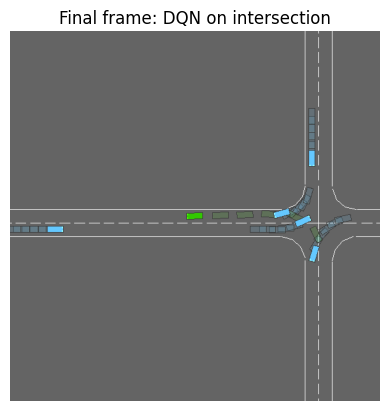

Total reward for 1 episode: 8.19


In [13]:
# === Visual test ===
obs, _ = test_env.reset()
done = False
frames = []
total_reward = 0
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = test_env.step(action)
    done = terminated or truncated
    total_reward += reward
    frame = test_env.render()
    frames.append(frame)

plt.imshow(frames[-1])
plt.axis("off")
plt.title("Final frame: DQN on intersection")
plt.show()
print(f"Total reward for 1 episode: {total_reward:.2f}")


In [ ]:
tensorboard_log="ppo_sb3_intersection_tensorboard/"


In [35]:
import os
import glob
import numpy as np

from tensorboard.backend.event_processing import event_accumulator

# === DQN Log directory (change to "DQN_1" or "DQN_2" depending on run you want) ===
log_dir = "highway_dqn_intersection_tensorboard/DQN_1"


# === Get the event file ===

event_file = glob.glob(os.path.join(log_dir, "events.out.tfevents.*"))[0]

# === Load and parse TensorBoard logs ===
ea = event_accumulator.EventAccumulator(event_file)
ea.Reload()



In [36]:
print(ea.Tags()["scalars"])


['rollout/exploration_rate', 'time/fps', 'train/learning_rate', 'train/loss']


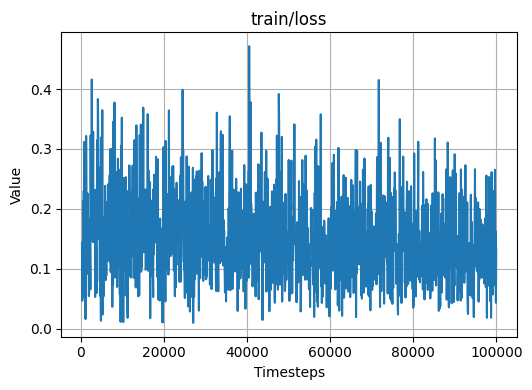

In [41]:
import matplotlib.pyplot as plt

metrics = [ "train/loss"]
plt.figure(figsize=(15, 4))

for i, tag in enumerate(metrics):
    events = ea.Scalars(tag)
    steps = [e.step for e in events]
    values = [e.value for e in events]

    plt.subplot(1, 3, i+1)
    plt.plot(steps, values, label=tag.split("/")[-1])
    plt.xlabel("Timesteps")
    plt.ylabel("Value")
    plt.title(tag)
    plt.grid()

plt.tight_layout()
plt.show()


In [21]:
import imageio

# === Visual test on one episode and save as GIF ===
obs, _ = test_env.reset()
done = False
frames = []
total_reward = 0

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = test_env.step(action)
    done = terminated or truncated
    total_reward += reward
    frame = test_env.render()  # RGB array
    frames.append(frame)



# Save to GIF
gif_path = "dqn_section_episode.gif"
imageio.mimsave(gif_path, frames, fps=15)  # 15 frames per second

print(f"Saved GIF to {gif_path}")
print(f"Total reward for 1 episode: {total_reward:.2f}")


Saved GIF to dqn_section_episode.gif
Total reward for 1 episode: 9.79



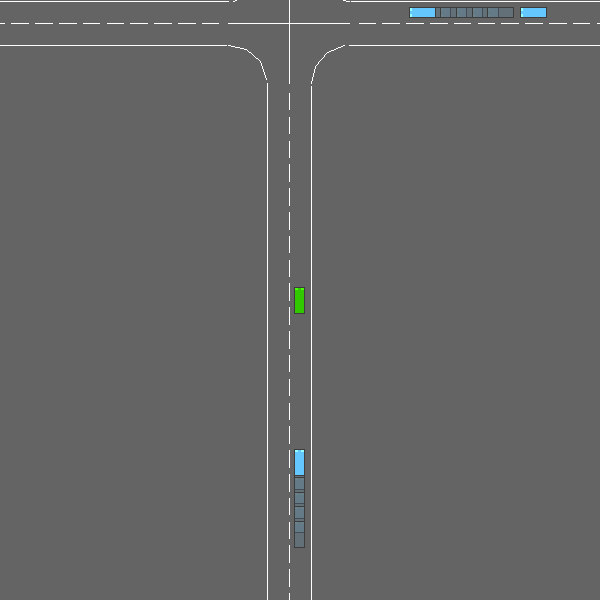

In [22]:
import base64, io
from IPython.display import HTML

def show_gif(frames, fps=30):
    import imageio, tempfile, os
    with tempfile.NamedTemporaryFile(suffix=".gif", delete=False) as fp:
        imageio.mimsave(fp.name, frames, fps=fps)
        data = base64.b64encode(open(fp.name,'rb').read()).decode("ascii")
    return HTML(f'<img src="data:image/gif;base64,{data}" />')
show_gif(frames, fps=30)